In [1]:
# random forest

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import re
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import sklearn.tree as tree
import random

In [3]:
os.getcwd()
# from thon.Choose import choose_features
from thon.churn_functions import modernize, out_eval, bake, simple_split
#data = choose_features("data/out/features.csv", cv_range = (0, 30), save = False)

In [4]:
data = pd.read_csv("data/out/features.csv")

In [5]:
X, y = data.drop(columns = ['n']), data['n']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, shuffle = False)
X_train, X_test, y_train, y_test = simple_split(X, y, (100, 120))

In [12]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state = 42,
                                   bootstrap=False, # no bootstrapping cause TS
                                   max_features="sqrt",
                                   n_estimators=250))
])

In [13]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(bootstrap=False, max_features='sqrt',
                                       n_estimators=250, random_state=42))])

In [18]:
pipeline.feature_names_in_

array(['10yinf_lag12', 'altsales_lag3', 'AN_lag12', 'AN_v_lag3',
       'BWA_lag12', 'BWA_v_lag6', 'caput_lag9', 'carcpi_lag12',
       'cbpy30_lag3', 'discount_lag3', 'durable_lag9', 'F_lag12',
       'F_v_lag6', 'fedfundseff_lag3', 'fedsurplus_lag3', 'food_lag12',
       'g_best_new_cars_lag9', 'g_car_for_sale_near_me_lag3',
       'g_cars_for_sale_lag12', 'g_dealership_near_me_lag3',
       'g_dealerships_near_me_lag3', 'g_how_to_buy_a_car_lag9',
       'g_new_cars_lag3', 'g_used_cars_lag3', 'GT_lag3', 'GT_v_lag12',
       'hcpi_lag3', 'hcpiurban_lag3', 'HMC_lag12', 'HMC_v_lag3',
       'industry_lag9', 'industrycg_lag9', 'industryut_lag9',
       'kwhcost_lag3', 'laborpart_lag3', 'LEA_lag3', 'localrent_lag3',
       'ltrucksa_lag3', 'manufinv_lag12', 'manufsales_lag12', 'month',
       'MZDAY_v_lag3', 'new_units_lag6', 'newhouses_lag3', 'ngspot_lag3',
       'oilimport_lag12', 'overmanuf_lag6', 'pemplfin_lag3',
       'pemplmanuf_lag3', 'pempltot_lag3', 'prodmanuf_lag9', 'quarter',

In [15]:
# Training data

# Train the model

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state = 25,
                                    bootstrap=False,
                                    max_features="sqrt",
                                    n_estimators=250,
                                    max_depth = 3))
])

pipeline.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
pred_train = pd.Series(pipeline.predict(X_train), index=X_train.index)
pred_test = pd.Series(pipeline.predict(X_test), index=X_test.index)

In [24]:
from sklearn.inspection import permutation_importance
import time
start_time = time.time()
result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.DataFrame(result.importances_mean, index=pipeline.feature_names_in_, columns = ['importance'])

Elapsed time to compute the importances: 8.364 seconds


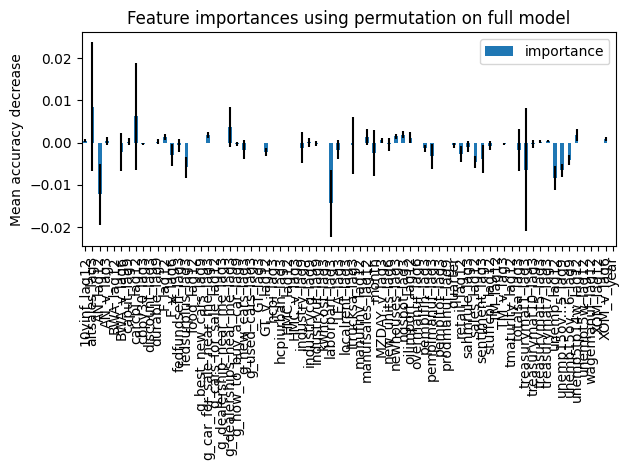

In [25]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [56]:
forest_importances = pd.Series(result.importances_mean, index=pipeline.feature_names_in_)
    
out = forest_importances[forest_importances > 0].index

In [57]:
len(out)

19

725.0738905951852
6.042282421626543


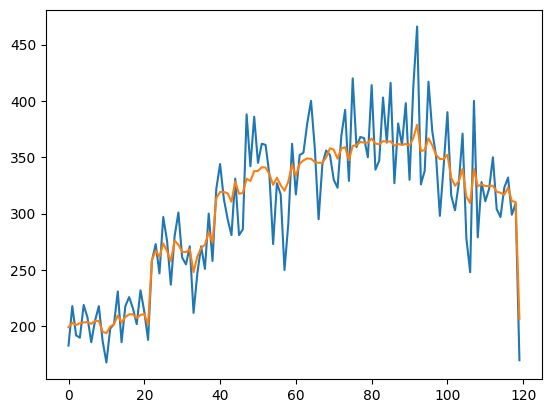

In [29]:
plot_eval(pred_train, y_train)

4589.931673120684
152.99772243735612


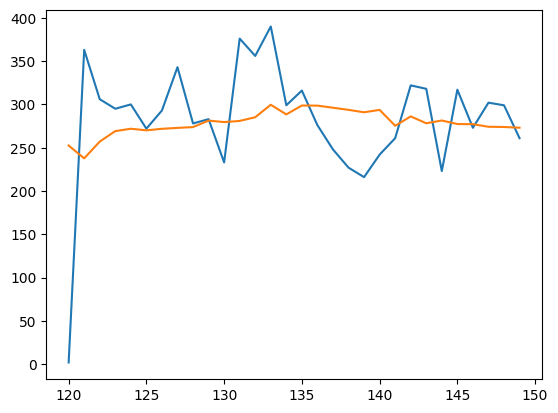

In [30]:
plot_eval(pred_test, y_test)

In [32]:
from thon.models import random
a = random.random_forest(split = (1, 100))

In [33]:
a

,actual,pred,group
0,183.0,183.0,train
1,390.0,183.0,test
2,316.0,183.0,test
3,303.0,183.0,test
4,327.0,183.0,test
5,371.0,183.0,test
6,278.0,183.0,test
7,248.0,183.0,test
8,400.0,183.0,test
9,279.0,183.0,test


In [23]:
pred = pipeline.predict(modernize(X_train))

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [32]:
out = bake(y_train, y_test, pred_train, pred_test, pred)

In [33]:
out

,actual,pred,group
0,183.0,199.322101,train
1,218.0,203.234849,train
2,192.0,201.229192,train
3,190.0,202.805414,train
4,219.0,203.460593,train
...,...,...,...
148,299.0,273.918571,test
149,261.0,273.093812,test
150,NaN,273.471059,pred
151,NaN,273.991088,pred


In [38]:
out.to_csv("data/out/random.csv")